In [1]:
%matplotlib inline

In [2]:
import xarray as xr
import seaborn as sns

What network should we use where?

In [3]:
files = [
    f"../data/output/model.{i}/0/1/columns.nc"
    for i in range(3)
]
truth_path = "../data/output/truth.nc"

In [4]:
truth = xr.open_dataset(truth_path)
w = truth.layer_mass

In [5]:
def plot_qt(file, x=0, y=18):
    (xr.open_dataset(file).qt - truth.qt[0].mean('x')).isel(x=x, y=y).plot.contourf(y='z')
    
def plot_sl(file, x=0, y=18):
    (xr.open_dataset(file).sl - truth.sl[0].mean('x')).isel(x=x, y=y).plot.contourf(y='z')

def error(file):
    ds = xr.open_dataset(file)
    return ((((ds - truth))**2*w).mean(['x', 'time', 'z'])/w.mean('z'))\
               .apply(np.sqrt)
    

In [6]:
# compute the errors for each network
errors = xr.concat([error(path) for i, path in enumerate(files)], dim='region')

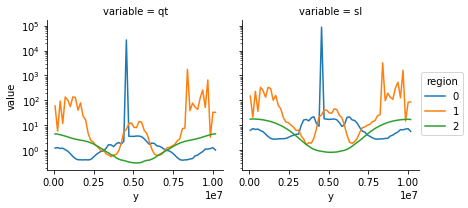

In [7]:
melted = errors.to_array().to_dataframe(name='value').reset_index()

fg = sns.FacetGrid(col="variable", hue="region", data=melted)
fg.map(plt.semilogy, "y", "value")
fg.add_legend()

The model trained on region 1 seems to perform worse than the other two models. This suggests that we should only use the region 0 (extra tropics) and region 2 (tropics) models. What does the tropics model looks like in the extra tropics?

/Users/noah/anaconda/envs/uw-machine-learning/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()
/Users/noah/anaconda/envs/uw-machine-learning/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


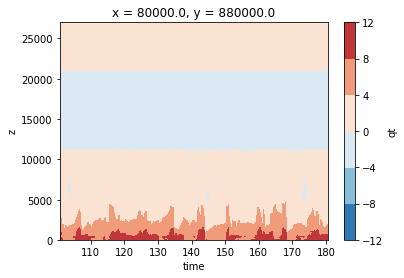

In [8]:
plot_qt(files[2], y=5)

It is far to moist. And vice versa?

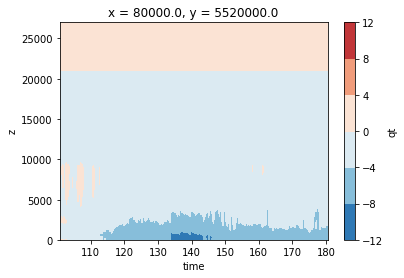

In [9]:
plot_qt(files[0], y=34)

The extratropics network dries out the atmosphere. What about the temperature field?

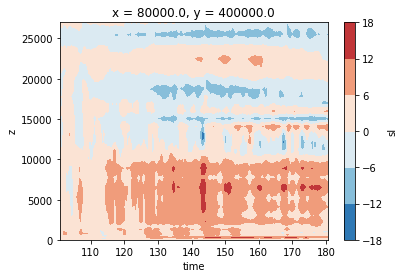

In [10]:
plot_sl(files[0], y=2)

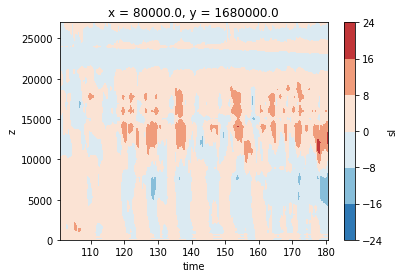

In [11]:
plot_sl(files[0], y=10)

The extra tropics model makes a very large bias near the edge of the domain, but it does better near the middle of its training region. Perhaps the model needs additional inputs at the edges, or we should train another network for just the 5 or so points near the edge of the domain. Ideally, we could find a model which works for the whole domain in one training procedure. I think a mixture of experts might be the way to go, but that might be hard to code up. Alternatively we could try to change the input variables (maybe RH would be better).